### XGBoost on Streptococcus pneumoniae

In [1]:
import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype
from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedGroupKFold, KFold
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_tree
from imblearn.over_sampling import SMOTE
from collections import Counter
from xgboost import plot_importance
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc,
    classification_report,
    precision_recall_curve,
    average_precision_score,
    roc_curve
)

In [2]:
sp = pd.read_csv('/Users/alexandra/Desktop/thesis_programming/final_SP.csv')

/var/folders/mx/knhr23fd09g19g__8gz1fgxh0000gn/T/ipykernel_22453/1758425030.py:1: DtypeWarning: Columns (184337) have mixed types. Specify dtype option on import or set low_memory=False.
  sp = pd.read_csv('/Users/alexandra/Desktop/thesis_programming/final_SP.csv')


In [3]:
# Separate feature columns and target labels
X = sp.drop(columns=["CHL","TET","AZM","sample_ID"], errors='ignore')

X['ST'] = pd.to_numeric(X['ST'], errors='coerce')  
X = X.dropna(subset=['ST'])

# Create individual datasets per antibiotic
# Split into features and labels
sp_chl = X.copy()
sp_chl['label'] = sp['CHL']
y_chl = sp_chl['label']

sp_tet = X.copy()
sp_tet['label'] = sp['TET']
y_tet = sp_tet['label']

sp_azm = X.copy()
sp_azm['label'] = sp['AZM']
y_azm = sp_azm['label']

In [4]:
# Train-test split
X_train_chl, X_test_chl, y_train_chl, y_test_chl = train_test_split(
    X, y_chl, stratify=y_chl, test_size=0.3, random_state=42)

X_train_tet, X_test_tet, y_train_tet, y_test_tet = train_test_split(
    X, y_tet, stratify=y_tet, test_size=0.3, random_state=42)

X_train_azm, X_test_azm, y_train_azm, y_test_azm = train_test_split(
    X, y_azm, stratify=y_azm, test_size=0.3, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled_chl, y_train_resampled_chl = smote.fit_resample(X_train_chl, y_train_chl)
X_train_resampled_azm, y_train_resampled_azm = smote.fit_resample(X_train_azm, y_train_azm)

print("CHL Resampled Class Distribution:", Counter(y_train_resampled_chl))
print("AZM Resampled Class Distribution:", Counter(y_train_resampled_azm))

CHL Resampled Class Distribution: Counter({0: 344, 1: 344})
AZM Resampled Class Distribution: Counter({0: 275, 1: 275})


### Blocked cross-validation

In [5]:
hparam = {"eta":[0.1, 0.2, 0.4, 0.8]}

In [6]:
# Prepare X and groups (drop ST from X, but use it for grouping)
groups_chl = X_train_resampled_chl['ST'].values
X_train_input_chl = X_train_resampled_chl.drop(columns=['ST'])

# Prepare X and groups (drop ST from X, but use it for grouping)
groups_tet = X_train_tet['ST'].values
X_train_input_tet = X_train_tet.drop(columns=['ST'])

# Prepare X and groups (drop ST from X, but use it for grouping)
groups_azm = X_train_resampled_azm['ST'].values
X_train_input_azm = X_train_resampled_azm.drop(columns=['ST'])

##### 1. CHL

In [7]:
model_chl = XGBClassifier(random_state=42)

cv = StratifiedGroupKFold(n_splits=4)
# Grid search
grid = GridSearchCV(estimator=model_chl, param_grid=hparam, cv=cv, refit='f1_macro', return_train_score=True, scoring='f1_macro')
grid_result = grid.fit(X_train_input_chl, y_train_resampled_chl, groups=groups_chl, verbose=0)
params_chl = grid_result.best_params_

# Output
print(f"Best Accuracy: {grid_result.best_score_:.4f}")
print(f"Best Parameters: {grid_result.best_params_}")

Best Accuracy: 0.9986
Best Parameters: {'eta': 0.1}


##### 2. TET

In [10]:
model_tet = XGBClassifier(random_state=42)

cv = StratifiedGroupKFold(n_splits=4)
# Grid search
grid = GridSearchCV(estimator=model_tet, param_grid=hparam, cv=cv, refit='f1_macro', return_train_score=True, scoring='f1_macro')
grid_result = grid.fit(X_train_input_tet, y_train_tet, groups=groups_tet, verbose=0)
params_tet = grid_result.best_params_

# Output
print(f"Best Accuracy: {grid_result.best_score_:.4f}")
print(f"Best Parameters: {grid_result.best_params_}")

Best Accuracy: 0.9890
Best Parameters: {'eta': 0.1}


##### 3. AZM

In [11]:
model_azm = XGBClassifier(random_state=42)

cv = StratifiedGroupKFold(n_splits=4)
# Grid search
grid = GridSearchCV(estimator=model_azm, param_grid=hparam, cv=cv, refit='f1_macro', return_train_score=True, scoring='f1_macro')
grid_result = grid.fit(X_train_input_azm, y_train_resampled_azm, groups=groups_azm, verbose=0)
params_azm = grid_result.best_params_

# Output
print(f"Best Accuracy: {grid_result.best_score_:.4f}")
print(f"Best Parameters: {grid_result.best_params_}")

Best Accuracy: 0.9928
Best Parameters: {'eta': 0.2}


### Training with best hyperparameters and testing

In [12]:
def run_GB(X_train, y_train, params):
  GB =  XGBClassifier(random_state = 42, eta=params['eta'])
  # Training XGB Classifier model
  GB = GB.fit(X_train, y_train)
  # Checking number of trees in the model
  print("Number of Decicion Trees in XGB Classifier model:", GB.get_booster().trees_to_dataframe().shape[0]
)
  return GB

In [13]:
def evaluate(model, X_train, y_train, X_test, y_test, threshold=0.5, model_name=None):
    """
    Evaluates a binary classification XGBoost model, compares training vs test accuracy,
    includes per-class metrics, and plots ROC and Precision-Recall curves.

    Parameters:
        model: Trained XGBoost model
        X_train, y_train: Training data (for overfitting check)
        X_test, y_test: Test data (for evaluation)
        threshold: Threshold for class prediction
    """
    # Predict probabilities
    y_test_prob = model.predict_proba(X_test)[:, 1]
    y_train_prob = model.predict_proba(X_train)[:, 1]

    # Apply threshold
    y_test_pred = (y_test_prob >= threshold).astype(int)
    y_train_pred = (y_train_prob >= threshold).astype(int)

    # Core metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    prec = precision_score(y_test, y_test_pred, zero_division=0)
    rec = recall_score(y_test, y_test_pred, zero_division=0)
    f1 = f1_score(y_test, y_test_pred, zero_division=0)
    cm = confusion_matrix(y_test, y_test_pred)
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    roc_auc = auc(fpr, tpr)

    # Classification report (per class)
    report = classification_report(
        y_test, y_test_pred, target_names=["Susceptible", "Resistant"], output_dict=True
    )

    # Display confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix for XGBoost model of {}".format(model_name))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for XGBoost model of {}'.format(model_name))
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()

    # Compute precision-recall values
    precision, recall, _ = precision_recall_curve(y_test, y_test_prob)

    # Compute PR AUC (Average Precision)
    pr_auc = average_precision_score(y_test, y_test_prob)

    # Plot Precision-Recall Curve
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("Precision-Recall Curve for XGBoost model of {}".format(model_name))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print summary
    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy:     {test_acc:.4f}")
    print(f"Overall Precision: {prec:.4f}")
    print(f"Overall Recall:    {rec:.4f}")
    print(f"Overall F1 Score:  {f1:.4f}")
    print(f"ROC AUC:           {roc_auc:.4f}")

    print("\nPer-Class Performance:")
    for cls in ["Susceptible", "Resistant"]:
        cls_metrics = report[cls]
        print(f"{cls:12} | Precision: {cls_metrics['precision']:.2f} | Recall: {cls_metrics['recall']:.2f} | F1: {cls_metrics['f1-score']:.2f}")

    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_test_pred, target_names=["Susceptible", "Resistant"]))

In [14]:
# Separate feature columns and target labels
X = sp.drop(columns=["CHL","TET","AZM","sample_ID",'ST'], errors='ignore')

# Create individual datasets per antibiotic
# Split into features and labels
sp_chl = X.copy()
sp_chl['label'] = sp['CHL']
y_chl = sp_chl['label']

sp_tet = X.copy()
sp_tet['label'] = sp['TET']
y_tet = sp_tet['label']

sp_azm = X.copy()
sp_azm['label'] = sp['AZM']
y_azm = sp_azm['label']

# Train-test split
X_train_chl, X_test_chl, y_train_chl, y_test_chl = train_test_split(
    X, y_chl, stratify=y_chl, test_size=0.3, random_state=42)

X_train_tet, X_test_tet, y_train_tet, y_test_tet = train_test_split(
    X, y_tet, stratify=y_tet, test_size=0.3, random_state=42)

X_train_azm, X_test_azm, y_train_azm, y_test_azm = train_test_split(
    X, y_azm, stratify=y_azm, test_size=0.3, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled_chl, y_train_resampled_chl = smote.fit_resample(X_train_chl, y_train_chl)
X_train_resampled_azm, y_train_resampled_azm = smote.fit_resample(X_train_azm, y_train_azm)

print("CHL Resampled Class Distribution:", Counter(y_train_resampled_chl))
print("AZM Resampled Class Distribution:", Counter(y_train_resampled_azm))

# X_train_resampled_* for training (70%)
# X_test_* for testing (30%)

CHL Resampled Class Distribution: Counter({0: 379, 1: 379})
AZM Resampled Class Distribution: Counter({1: 295, 0: 295})


##### 1. CHL

Number of Decicion Trees in XGB Classifier model: 380


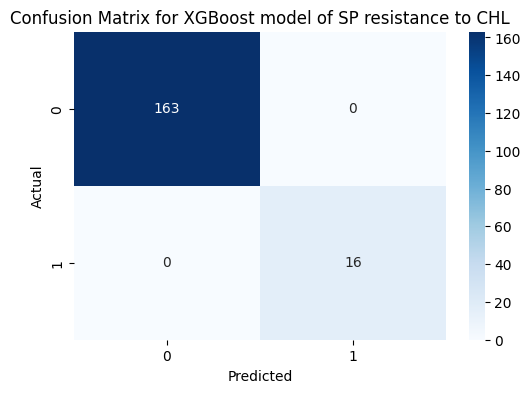

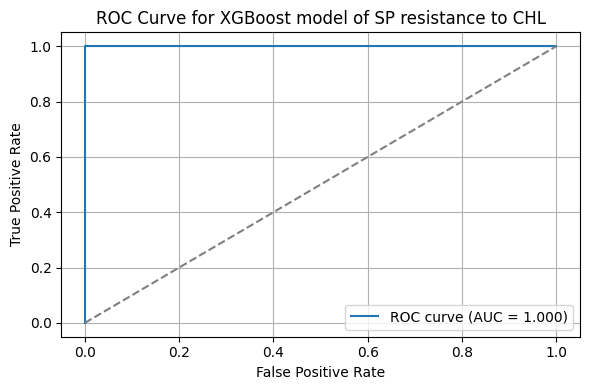

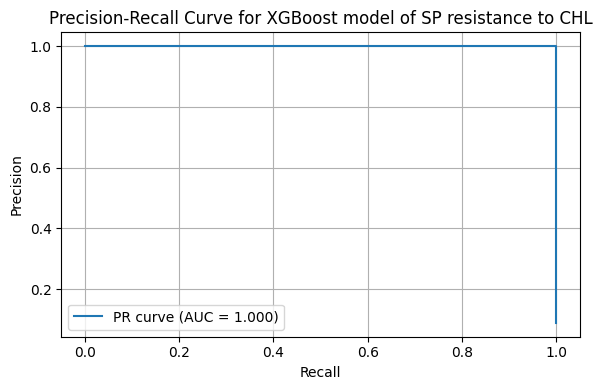

Training Accuracy: 1.0000
Test Accuracy:     1.0000
Overall Precision: 1.0000
Overall Recall:    1.0000
Overall F1 Score:  1.0000
ROC AUC:           1.0000

Per-Class Performance:
Susceptible  | Precision: 1.00 | Recall: 1.00 | F1: 1.00
Resistant    | Precision: 1.00 | Recall: 1.00 | F1: 1.00

Detailed Classification Report:
              precision    recall  f1-score   support

 Susceptible       1.00      1.00      1.00       163
   Resistant       1.00      1.00      1.00        16

    accuracy                           1.00       179
   macro avg       1.00      1.00      1.00       179
weighted avg       1.00      1.00      1.00       179



In [15]:
model_chl = run_GB(X_train_resampled_chl, y_train_resampled_chl, params_chl)
evaluate(model_chl, X_train_resampled_chl, y_train_resampled_chl, X_test_chl, y_test_chl, model_name="SP resistance to CHL")

##### 2. TET

Number of Decicion Trees in XGB Classifier model: 412


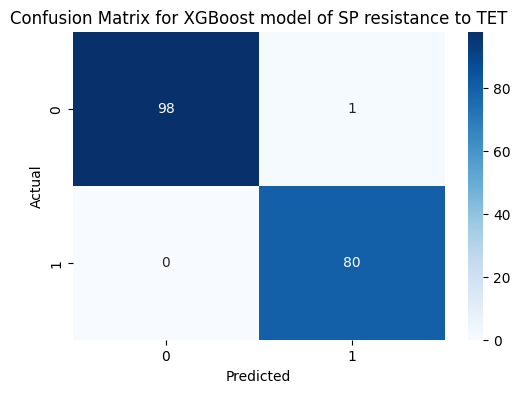

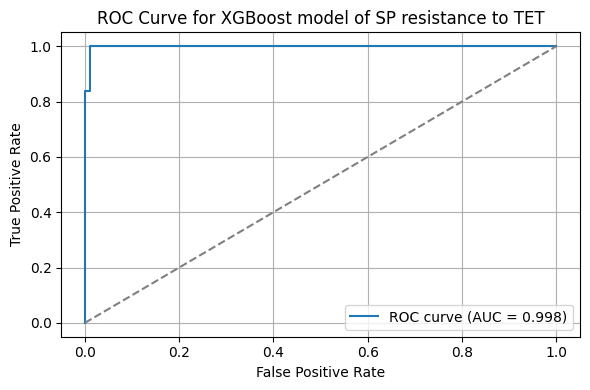

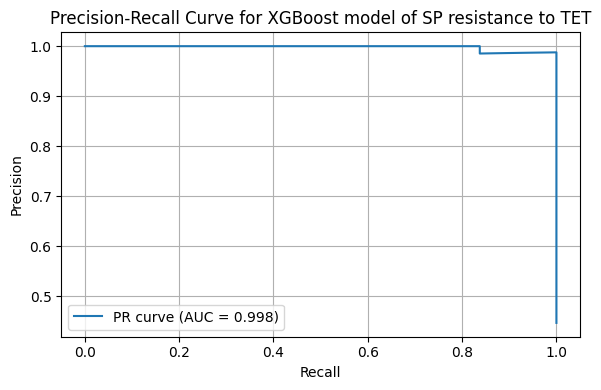

Training Accuracy: 1.0000
Test Accuracy:     0.9944
Overall Precision: 0.9877
Overall Recall:    1.0000
Overall F1 Score:  0.9938
ROC AUC:           0.9984

Per-Class Performance:
Susceptible  | Precision: 1.00 | Recall: 0.99 | F1: 0.99
Resistant    | Precision: 0.99 | Recall: 1.00 | F1: 0.99

Detailed Classification Report:
              precision    recall  f1-score   support

 Susceptible       1.00      0.99      0.99        99
   Resistant       0.99      1.00      0.99        80

    accuracy                           0.99       179
   macro avg       0.99      0.99      0.99       179
weighted avg       0.99      0.99      0.99       179



In [16]:
model_tet = run_GB(X_train_tet, y_train_tet, params_tet)
evaluate(model_tet, X_train_tet, y_train_tet, X_test_tet, y_test_tet, model_name='SP resistance to TET')

##### 3. AZM

Number of Decicion Trees in XGB Classifier model: 482


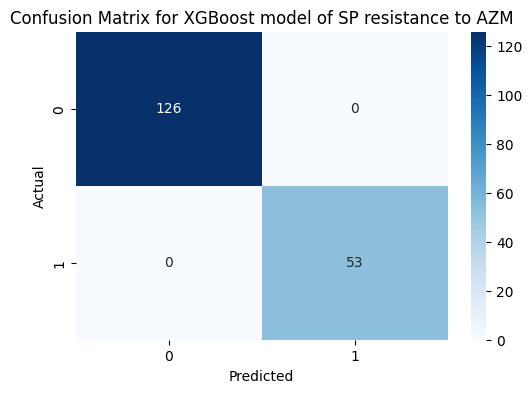

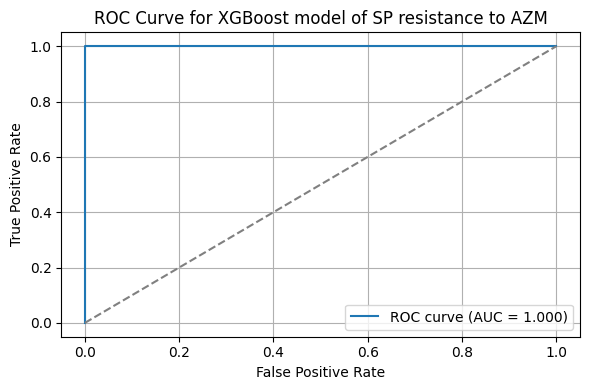

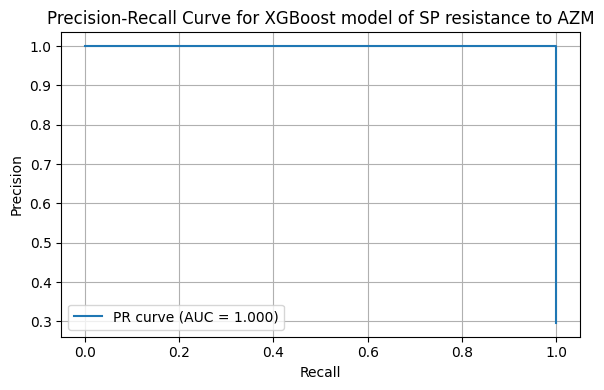

Training Accuracy: 1.0000
Test Accuracy:     1.0000
Overall Precision: 1.0000
Overall Recall:    1.0000
Overall F1 Score:  1.0000
ROC AUC:           1.0000

Per-Class Performance:
Susceptible  | Precision: 1.00 | Recall: 1.00 | F1: 1.00
Resistant    | Precision: 1.00 | Recall: 1.00 | F1: 1.00

Detailed Classification Report:
              precision    recall  f1-score   support

 Susceptible       1.00      1.00      1.00       126
   Resistant       1.00      1.00      1.00        53

    accuracy                           1.00       179
   macro avg       1.00      1.00      1.00       179
weighted avg       1.00      1.00      1.00       179



In [17]:
model_azm = run_GB(X_train_resampled_azm, y_train_resampled_azm, params_azm)
evaluate(model_azm, X_train_resampled_azm, y_train_resampled_azm, X_test_azm, y_test_azm, model_name='SP resistance to AZM')

### Feature importance

##### 1. CHL

In [18]:
booster_chl = model_chl.get_booster()

# Get feature importance by gain (how much each feature improves performance when used)
importance_dict = booster_chl.get_score(importance_type='gain')

# Sort features by gain (descending) and take the top 20
top_20_features = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)[:20]

# Print top 20
print("Top 20 features by importance (gain):")
for feature, score in top_20_features:
    print(f"{feature}: {score:.4f}")


Top 20 features by importance (gain):
cat: 111.4596
group_3968: 3.7431
SNP_1652: 2.5920
group_1470: 2.5381
SNP_110749: 2.4435
SNP_129614: 2.4167
SNP_14935: 2.2613
SNP_172399: 2.1879
group_2311: 2.1723
SNP_13909: 2.1129
SNP_41623: 2.0372
group_3901: 1.9255
SNP_22823: 1.9214
SNP_40518: 1.8482
SNP_62718: 1.7785
SNP_151828: 1.6885
SNP_94016: 1.6042
SNP_5410: 1.5422
SNP_50875: 1.5033
SNP_99838: 1.4644


##### 2. TET

In [19]:
booster_tet = model_tet.get_booster()

# Get feature importance by gain (how much each feature improves performance when used)
importance_dict = booster_tet.get_score(importance_type='gain')

# Sort features by gain (descending) and take the top 20
top_20_features = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)[:20]

# Print top 20
print("Top 20 features by importance (gain):")
for feature, score in top_20_features:
    print(f"{feature}: {score:.4f}")


Top 20 features by importance (gain):
tetM~~~tetM: 51.5613
group_1908: 3.0341
SNP_18127: 2.9268
SNP_20862: 2.8556
SNP_49164: 2.8068
SNP_57304: 2.6557
SNP_79490: 2.6440
SNP_157035: 2.5178
SNP_73928: 2.3471
SNP_62886: 2.3211
SNP_62514: 2.1828
group_2131: 2.1181
SNP_113800: 1.9871
SNP_20869: 1.8898
SNP_37850: 1.8070
group_2240: 1.7177
SNP_157964: 1.6822
SNP_171423: 1.6170
SNP_79614: 1.5537
SNP_95128: 1.5105


##### 3. AZM

In [20]:
booster_azm = model_azm.get_booster()

# Get feature importance by gain (how much each feature improves performance when used)
importance_dict = booster_azm.get_score(importance_type='gain')

# Sort features by gain (descending) and take the top 20
top_20_features = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)[:20]

# Print top 20
print("Top 20 features by importance (gain):")
for feature, score in top_20_features:
    print(f"{feature}: {score:.4f}")


Top 20 features by importance (gain):
group_2302: 120.8449
group_3059: 25.8074
SNP_50163: 23.5318
group_942: 20.7909
SNP_85425: 17.5218
SNP_131644: 12.2937
SNP_110383: 10.9094
SNP_161178: 10.1620
group_2303: 9.4705
SNP_129714: 5.5877
group_2333: 5.2150
group_3612: 4.1739
SNP_10552: 3.9694
SNP_70101: 3.6774
SNP_88232: 3.6476
SNP_18860: 2.7554
SNP_20426: 2.2791
group_3306: 2.1667
SNP_85749: 2.0668
nanA_1~~~nanA_2~~~nanA_3: 1.9626
